# Autoencoder

In [65]:
#import numpy and keras modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

#import Scanpy modules
import scanpy as sc
import anndata
from scipy import sparse

#import os
import os
import matplotlib
import matplotlib.pyplot as plt

## Load the dataset

In [4]:
#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'data', 'raw')

#Name of data set
dataset_name = 'large_atac_gene_activity'

# read dataset into an anndata object:  Category - Cells of the brain
inPath = os.path.join(base_path, f"{dataset_name}.h5ad")
adata = sc.read(inPath)

## Prepare data

In [ ]:
#---Prepare Data---
INPUT =  adata.X.toarray()
print(INPUT.shape) # array: each row corresponding to one cell, each collumn to one gene
INPUT_size = INPUT[0].size

(84813, 3580)


3580

## Basic autoencoder
Input: Gene Expression Matrix, Output: Corrected Gene Expression Matrix

In [18]:
#---Build the model---

#Initilize the encoder
encoder = Sequential()
#Hyperparameters
N_HIDDEN = 256 # Dimension which the Encoder reduces the image to
ACTIVATION_FUNCTION_ENCODER = 'relu'
# add one dense hidden layer to the encoder, with the input size 3580 and the output size 256
encoder.add(Dense(N_HIDDEN, input_shape=(INPUT_size,), activation=ACTIVATION_FUNCTION_ENCODER))

#Initilize the decoder
decoder = Sequential()
#Hyperparameters
ACTIVATION_FUNCTION_DECODER = 'linear'
# add one output layer to the decoder, with the input size 64 (hidden layer of the encoder) and the output size 784
decoder.add(Dense(INPUT_size, activation=ACTIVATION_FUNCTION_ENCODER))

# Define the autoencoder model
input = tf.keras.Input(shape=(INPUT_size,)) #Generic input
encoded = encoder(input) #encoder input
decoded = decoder(encoded)  #decoder input

autoencoder = tf.keras.Model(input, decoded) #autoencoder: takes input_img and returns decoded picture

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse') #adam: type of optimizer used to minimize the loss function. mse: loss function. difference between input and output

autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3580)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256)            │       916,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 3580)           │       920,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,836,796 (7.01 MB)

 Trainable params: 1,836,796 (7.01 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#---Train the model---

# The autoencoder fits the data to the data -> in the end nothing should change
history = autoencoder.fit(INPUT, INPUT,
                epochs=20,
                batch_size=30,
                shuffle=True, 
                validation_data=(INPUT, INPUT),
                verbose=2) # shuffle the data after each epoch to reduce overfitting, 


Epoch 1/20
2828/2828 - 19s - 7ms/step - loss: 0.0625 - val_loss: 0.0616
Epoch 2/20
2828/2828 - 18s - 6ms/step - loss: 0.0616 - val_loss: 0.0612
Epoch 3/20
2828/2828 - 19s - 7ms/step - loss: 0.0609 - val_loss: 0.0608
Epoch 4/20
2828/2828 - 18s - 7ms/step - loss: 0.0605 - val_loss: 0.0606
Epoch 5/20
2828/2828 - 18s - 6ms/step - loss: 0.0603 - val_loss: 0.0607
Epoch 6/20
2828/2828 - 17s - 6ms/step - loss: 0.0601 - val_loss: 0.0602
Epoch 7/20
2828/2828 - 17s - 6ms/step - loss: 0.0600 - val_loss: 0.0600
Epoch 8/20
2828/2828 - 17s - 6ms/step - loss: 0.0599 - val_loss: 0.0599
Epoch 9/20
2828/2828 - 18s - 6ms/step - loss: 0.0598 - val_loss: 0.0600
Epoch 10/20
2828/2828 - 19s - 7ms/step - loss: 0.0598 - val_loss: 0.0601
Epoch 11/20
2828/2828 - 18s - 6ms/step - loss: 0.0597 - val_loss: 0.0600
Epoch 12/20
2828/2828 - 18s - 6ms/step - loss: 0.0597 - val_loss: 0.0598
Epoch 13/20
2828/2828 - 17s - 6ms/step - loss: 0.0597 - val_loss: 0.0598
Epoch 14/20
2828/2828 - 17s - 6ms/step - loss: 0.0596 - val_

<function matplotlib.pyplot.show(close=None, block=None)>

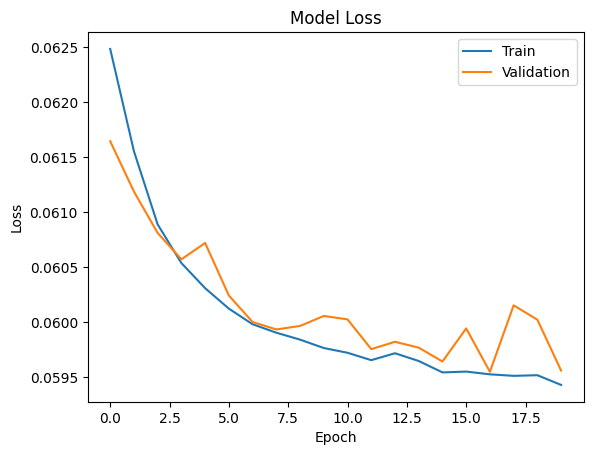

In [ ]:
#--Visualisize Training---
# Plot training & validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show
#validation and training loss decreases

In [91]:
#autoencode data
autoencoded_data = autoencoder.predict(INPUT)
#Create sparse matrix
autoencoded_data = sparse.csr_matrix(autoencoded_data)
#create anndata object
OUTPUT = anndata.AnnData(autoencoded_data)
#Take metadata from input
OUTPUT.obs = adata.obs
OUTPUT.var= adata.var

2651/2651 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step


In [ ]:
print(OUTPUT.X[:, 0])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2706 stored elements and shape (84813, 1)>
  Coords	Values
  (0, 0)	0.06102699786424637
  (8, 0)	0.09357307851314545
  (9, 0)	0.06207481771707535
  (14, 0)	0.212656170129776
  (21, 0)	0.1219126358628273
  (42, 0)	0.1493215560913086
  (43, 0)	0.20400655269622803
  (46, 0)	0.07145553827285767
  (48, 0)	0.11724486947059631
  (49, 0)	0.23819220066070557
  (53, 0)	0.11499820649623871
  (63, 0)	0.06770697981119156
  (90, 0)	0.22892789542675018
  (97, 0)	0.07462038099765778
  (98, 0)	0.1021224856376648
  (121, 0)	0.12353186309337616
  (150, 0)	0.09785345196723938
  (151, 0)	0.2700493633747101
  (152, 0)	0.08373324573040009
  (163, 0)	0.1425113081932068
  (187, 0)	0.19945783913135529
  (193, 0)	0.07186930626630783
  (195, 0)	0.08937191963195801
  (252, 0)	0.08105342835187912
  (258, 0)	0.06771313399076462
  :	:
  (84064, 0)	0.39908093214035034
  (84115, 0)	0.4141508638858795
  (84179, 0)	0.7270009517669678
  (84226, 0)	0.34618142247

In [93]:
print(adata.X[:, 0])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2706 stored elements and shape (84813, 1)>
  Coords	Values
  (0, 0)	0.06102699786424637
  (8, 0)	0.09357307851314545
  (9, 0)	0.06207481771707535
  (14, 0)	0.212656170129776
  (21, 0)	0.1219126358628273
  (42, 0)	0.1493215560913086
  (43, 0)	0.20400655269622803
  (46, 0)	0.07145553827285767
  (48, 0)	0.11724486947059631
  (49, 0)	0.23819220066070557
  (53, 0)	0.11499820649623871
  (63, 0)	0.06770697981119156
  (90, 0)	0.22892789542675018
  (97, 0)	0.07462038099765778
  (98, 0)	0.1021224856376648
  (121, 0)	0.12353186309337616
  (150, 0)	0.09785345196723938
  (151, 0)	0.2700493633747101
  (152, 0)	0.08373324573040009
  (163, 0)	0.1425113081932068
  (187, 0)	0.19945783913135529
  (193, 0)	0.07186930626630783
  (195, 0)	0.08937191963195801
  (252, 0)	0.08105342835187912
  (258, 0)	0.06771313399076462
  :	:
  (84064, 0)	0.39908093214035034
  (84115, 0)	0.4141508638858795
  (84179, 0)	0.7270009517669678
  (84226, 0)	0.34618142247

In [90]:
np.count_nonzero(INPUT) - np.count_nonzero(autoencoded_data) 

14653596

c:\Users\lklei\anaconda3\envs\Tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


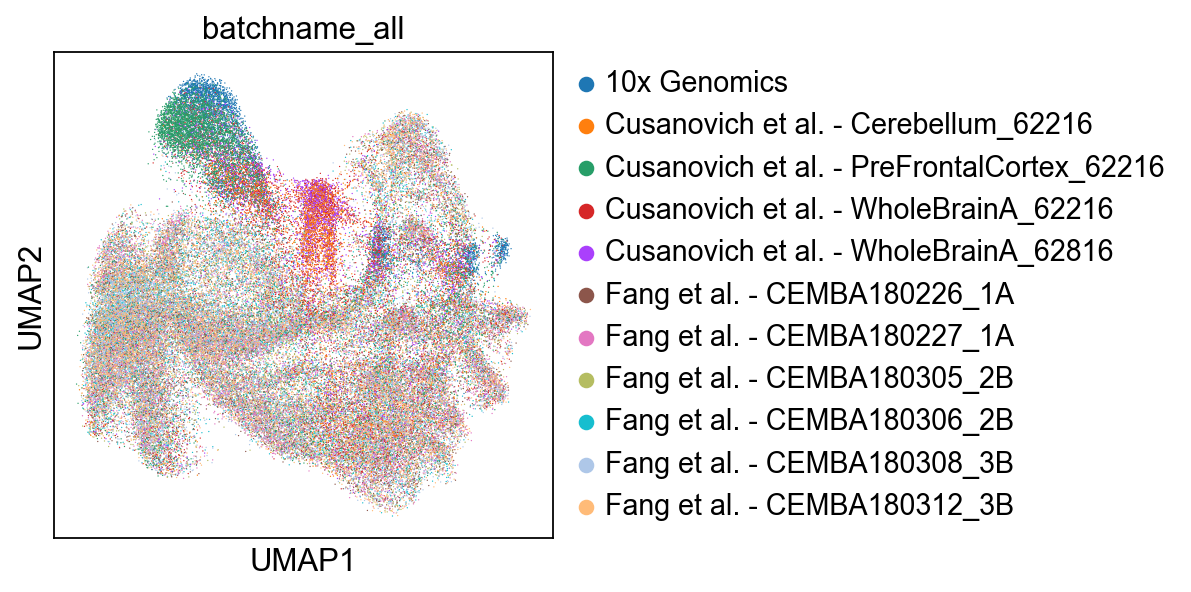

In [ ]:
# --- Plot original data ---
#Options for plotting
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)
batch_key = 'batchname_all'

# Dimensionality Reduction of Data
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False) #coloured by batch


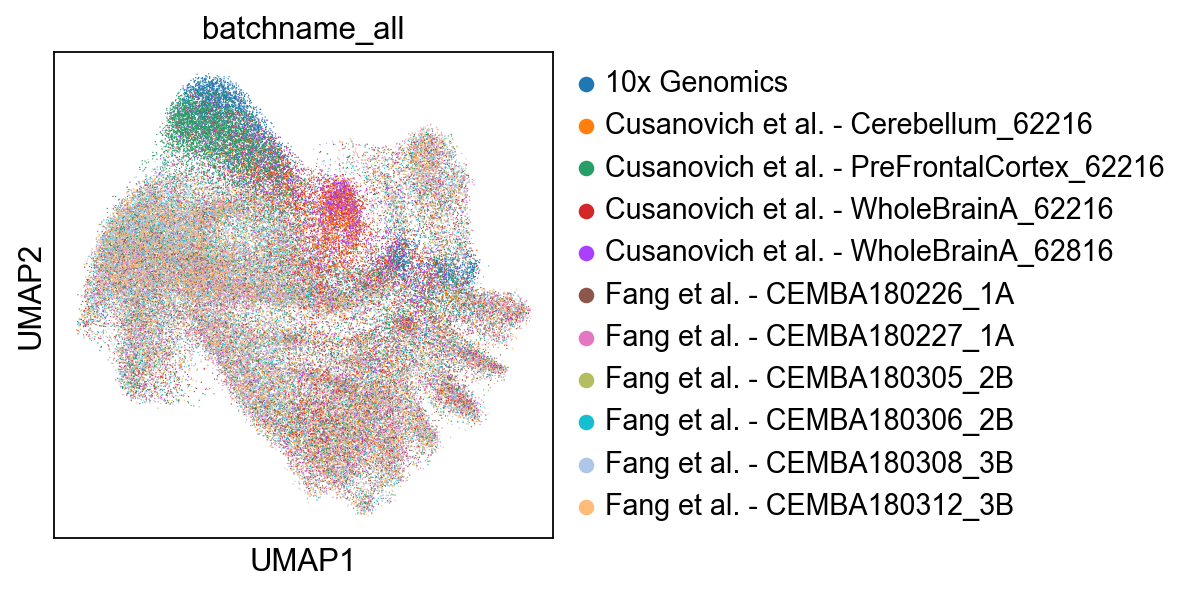

In [ ]:
# --- Plot autoencoded data ---
#Options for plotting
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)
batch_key = 'batchname_all'

# Dimensionality Reduction of Data
sc.pp.pca(OUTPUT, svd_solver="arpack")
sc.pp.neighbors(OUTPUT, n_neighbors=25)
sc.tl.umap(OUTPUT, random_state=42)
sc.pl.umap(OUTPUT, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False) #coloured by batch

#Data similar but not the same ! autoencoding succssefull